In [1]:
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

In [2]:
insurance = pd.read_csv(os.getcwd() + '\\data\\insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance.describe(include="all")

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


Skewness: 1.5141797118745743
Kurtosis: 1.595821363956751


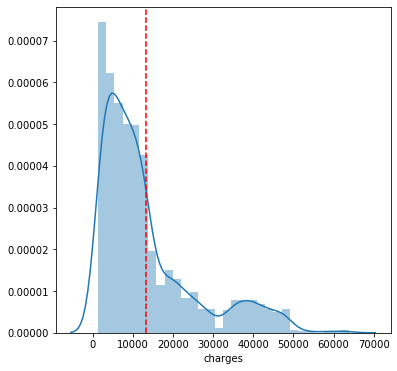

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.distplot(insurance['charges'])
ax.axvline(np.mean(insurance['charges']),  ls='--', color='r')

#skewness & kurtosis
print("Skewness:",  stats.skew(insurance['charges']))
print("Kurtosis:",  stats.kurtosis(insurance['charges']))

Skewness: -0.08999648706579925
Kurtosis: -0.6387709043691343


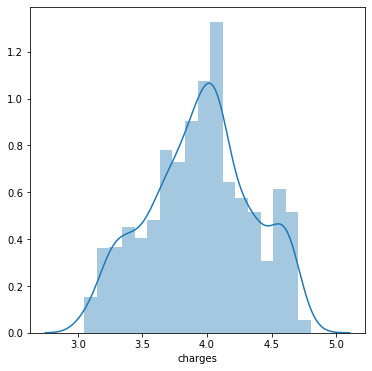

In [5]:
#Log transformation on dependent variable
charges_norm = np.log10(insurance['charges'])
fig, ax = plt.subplots(figsize=(6,6))
ax = sns.distplot(charges_norm)

#skewness & kurtosis
print("Skewness:",  stats.skew(charges_norm))
print("Kurtosis:",  stats.kurtosis(charges_norm))

In [6]:
#check for missing values
insurance.isnull().sum().sort_values(ascending=False)

charges     0
region      0
smoker      0
children    0
bmi         0
sex         0
age         0
dtype: int64

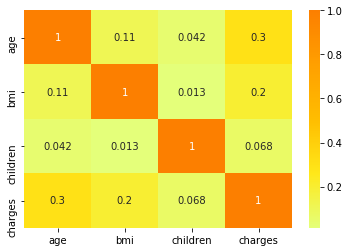

In [7]:
#check for correlation between variables
corr = insurance.corr(method='pearson')
sns.heatmap(corr, cmap = 'Wistia', annot=True)

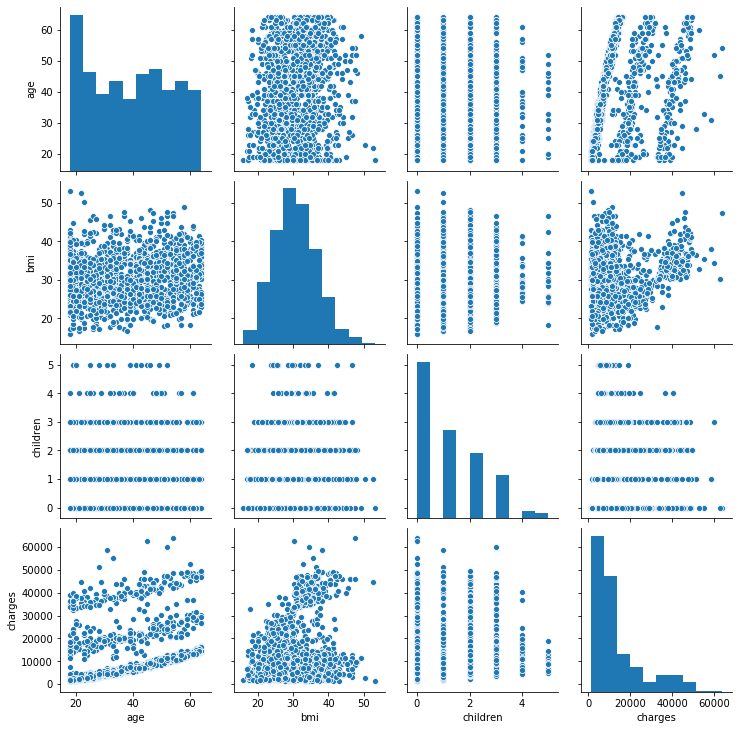

In [8]:
#check realtionns between continuous variables
sns.pairplot(data=insurance)

[0 1 3 2 5 4]


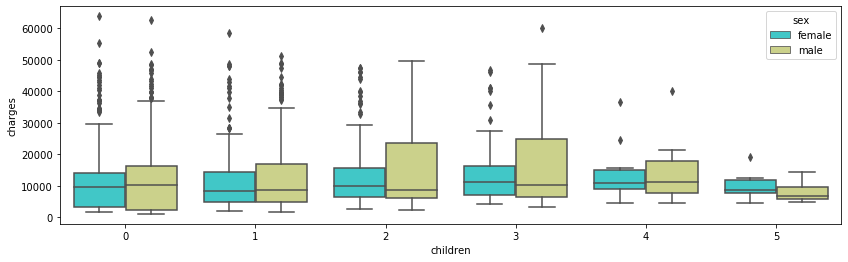

In [9]:
print(insurance['children'].unique())
plt.figure(figsize=(14,4))
sns.boxplot(x='children', y='charges', hue='sex', palette='rainbow', data=insurance)

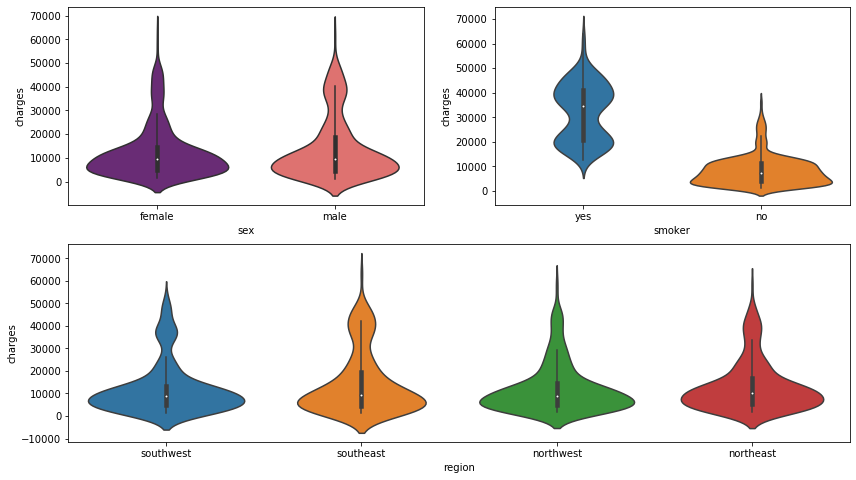

In [10]:
f = plt.figure(figsize=(14,8))
ax = f.add_subplot(221)
sns.violinplot(x='sex', y='charges',palette='magma', data=insurance, ax=ax)
ax2 = f.add_subplot(222)
sns.violinplot(x='smoker', y='charges', data=insurance, ax=ax2)
ax3 = f.add_subplot(212)
sns.violinplot(x='region', y='charges', data=insurance, ax=ax3)

In [11]:
#categories to numeric
df_ins = insurance
df_ins = pd.get_dummies(df_ins, prefix_sep='_', drop_first=True)

In [12]:
children_encode = pd.get_dummies(df_ins['children'], prefix='children', prefix_sep='_', drop_first=True)
df_ins.drop(columns=['children'], inplace=True)
df_encode = pd.concat([df_ins, children_encode], axis=1, sort=False)

In [13]:
#train test split
df_encode_y = df_encode['charges']
df_encode_x = df_encode.drop(columns=['charges'])
x_train, x_test, y_train, y_test = train_test_split(df_encode_x, df_encode_y)

In [14]:
x_train_const = sm.add_constant(x_train) #add constant
model = sm.OLS(y_train, x_train_const)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     262.6
Date:                Thu, 26 Nov 2020   Prob (F-statistic):          1.48e-297
Time:                        15:48:15   Log-Likelihood:                -10140.
No. Observations:                1003   AIC:                         2.031e+04
Df Residuals:                     990   BIC:                         2.037e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.238e+04   1144.582  

c:\users\edwinvivekn\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [17]:
y_fitted = results.fittedvalues
print("MSE: %.2f" % mean_squared_error(y_train, y_fitted))
print("RMSE/Standard Error: %.2f" % mean_squared_error(y_train, y_fitted, squared=False))

MSE: 35384810.71
RMSE/Standard Error: 5948.51


In [18]:
#comparing results with sklearn
lreg = LinearRegression()
lreg.fit(x_train, y_train)
y_pred = lreg.predict(x_train)
print("MSE: %.2f" % mean_squared_error(y_train, y_pred))
print("RMSE/Standard Error: %.2f" % mean_squared_error(y_train, y_pred, squared=False))
print("R-Squared", lreg.score(x_train, y_train))

MSE: 35384810.71
RMSE/Standard Error: 5948.51
R-Squared 0.7609479977634727


Text(0.5, 1.0, 'Check for Linearity:\n Actual Vs Predicted value')

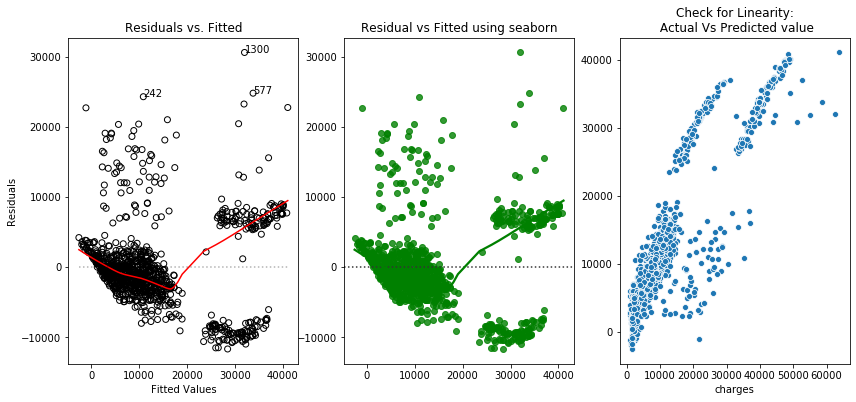

In [19]:
#linearity - residual vs fitted plot
smoothed = lowess(results.resid, y_fitted)
top3 = abs(pd.Series(results.resid)).sort_values(ascending = False)[:3]
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(131)
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.scatter(y_fitted, results.resid, edgecolors = 'k',  facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.plot([min(y_fitted),max(y_fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)
for i in top3.index:
    ax.annotate(i,xy=(y_fitted[i],results.resid[i]))

#Residual plot using seaborn
ax1 = f.add_subplot(132)
sns.residplot(y_fitted, results.resid, lowess=True, color='g', ax=ax1)
ax1.set_title('Residual vs Fitted using seaborn')

#Check for Linearity: Actual Vs Predicted value
ax2 = f.add_subplot(133)
sns.scatterplot(y_train, y_fitted, ax=ax2)
ax2.set_title('Check for Linearity:\n Actual Vs Predicted value')

MEan of residual (should be closer to 0): -1.468974493391968e-11


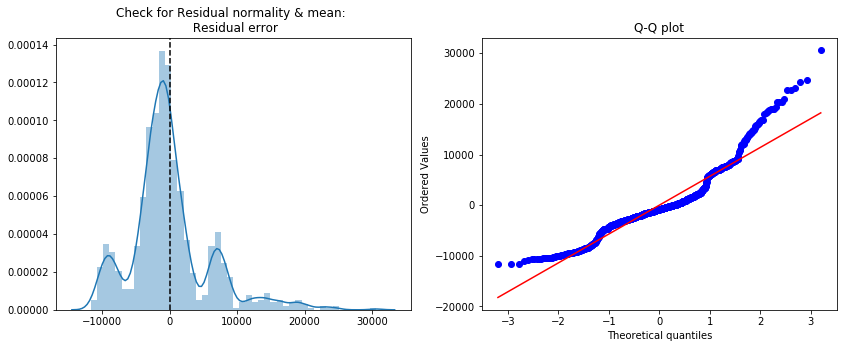

In [20]:
#normal dist of error terms - distribution plot , qq-plot
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.distplot(results.resid, ax=ax)
ax.axvline(results.resid.mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual error');

ax = f.add_subplot(122)
stats.probplot(results.resid, dist="norm", plot=plt)
ax.set_title('Q-Q plot');
print("MEan of residual (should be closer to 0):", np.mean(results.resid))

(0, 2.151763046044732)

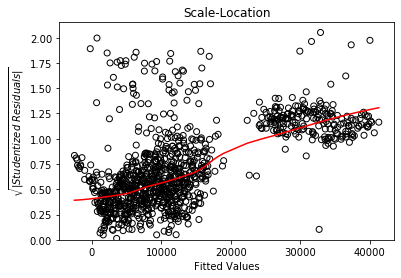

In [20]:
#homoscedasticity - scale-location plot
student_residuals = results.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = pd.Series(results.resid).index
smoothed = lowess(sqrt_student_residuals, y_fitted)

fig, ax = plt.subplots()
ax.scatter(y_fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+0.1)

In [22]:
#multicollinearity - scatterplot, pairplot, heatmap
vif = [variance_inflation_factor(x_train, i) for i in range(x_train .shape[1])]
print("VIF for each parameters:", vif)

In [ ]:
#autocorrelation - residual vs timeplot

In [ ]:
#outliers - residual vs levrage plot